### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

Come prima cosa mi sono andato a cercare il peaper dove viene presentato [ODIN]('https://arxiv.org/pdf/1706.02690') ho deciso di implementarlo sfruttando il modello dato ed addestrato dal professore 

In [3]:
import torch
import torchvision
from torchvision.datasets import FakeData
from torchvision import transforms
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [4]:
torch.cuda.is_available()

True

Il test li svolgerò cifar10  ed utilizzerò per come OOD  FakeData

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, # ho impostato la batch a 1 per semplificarmi il calcolo delle pertubazioni 
                                         shuffle=False, num_workers=8)

fakeset = FakeData(size=10000, image_size=(3, 32, 32), transform=transform)
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=1,
                                         shuffle=False, num_workers=8)



In [6]:
# A very simple CNN model.

class CNN(nn.Module):
    def __init__(self, dropout=False):
        super().__init__()
        self.dropout=dropout
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # downsample
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # downsample
        
        self.flatten_dim = 256 * 8 * 8  # assuming input is 32x32
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # -> 32x32x32
        x = F.relu(self.conv2(x))   # -> 32x32x64
        x = F.relu(self.conv3(x))   # -> 32x32x128
        x = F.relu(self.conv4(x))   # -> 16x16x128
        x = F.relu(self.conv5(x))   # -> 8x8x256
        x = torch.flatten(x, 1)
        if self.dropout:
            x = F.dropout(F.relu(self.fc1(x)))
            x = F.dropout(F.relu(self.fc2(x)))
        else:
            x = (F.relu(self.fc1(x)))
            x = (F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


Per semplicità come consigliato nel peaper per calcolare le perturbazioni di utilizzare La cross entropy loss

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN(dropout= False).to(device)

loss =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [8]:
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

model = CNN().to(device)
model.load_state_dict(torch.load(f'./cifar10_CNN_{50}_{0.0001}.pth')) # modello dato dal professore  

<All keys matched successfully>

calcoliamoci gli score del test 

In [10]:
with torch.no_grad():
    scores_test = []
    T = 1
    for data in testloader: 
         x,y_true = data
         logits = model(x.to(device)) 
         prob = F.softmax(logits/T, 1)
         score = prob.max(dim=1)[0]
         y_pred = torch.argmax(prob)
         if(y_pred.to('cpu') ==  y_true):
             scores_test.append(score.to('cpu')) 
    scores_test = torch.cat(scores_test) 
    
    
scores_test.shape        

torch.Size([6403])

calcoliamoci gli score degli OOD

In [11]:
with torch.no_grad():
    scores_fake = []
    T = 1
    for data in fakeloader: 
         x,_ = data
         logits = model(x.to(device)) 
         prob = F.softmax(logits/T, 1)
         score = prob.max(dim=1)[0]
         scores_fake.append(score.to('cpu')) 
         if(len(scores_fake) == len(scores_test)):
            break
    scores_fake = torch.cat(scores_fake) 
    
scores_fake.shape
    

torch.Size([6403])

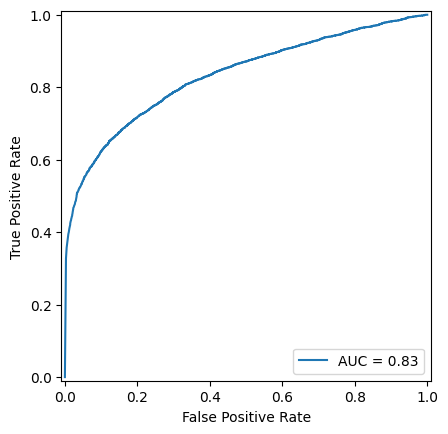

In [12]:
y_fake = torch.zeros_like(scores_fake)
y_test = torch.ones_like(scores_test)
ypred = torch.cat((scores_test, scores_fake))
ytrue = torch.cat((y_test, y_fake))

fpr, tpr, thresholds = metrics.roc_curve(ytrue, ypred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

ho definito una funzione ODIN che calcola gli score dell'imagine perturbata prendendo in ingresso il segno del gradiente l'immagine l'epislon e la temperatura

In [13]:
def ODIN(grad, x ,eps, T):
     model.eval()
     with torch.no_grad():
        perturbed_image = x- eps * grad
        logits =  model(perturbed_image.to(device))
        prob = F.softmax(logits/T, 1)
        score = prob.max(dim=1)[0]
        return score.to('cpu') 

Non sono riuscito a trovare un modo di fare backward un tensore di valori quindi ho preferito mettere la batch a 1 rendere il codice più pulito

abbiamo utilizzato la baseline proposta da [Hendrycks & Gimpel]('https://arxiv.org/pdf/1610.02136') (sezione 3, secondo paragrafo) come nel peaper quindi utilizzando solo i gli esempi correttamente classificati per gli esempi in distribuzione 

In [14]:
scores_test_ODIN = []
T = 1000
eps = 0.03
std_dev = 0.5
model.eval()
for data in testloader: 
    model.zero_grad()
    x,y_true = data
    x,y_true = x.to(device), y_true.to(device)
    x.requires_grad_()
    logits = model(x) 
    prob = F.softmax(logits/T, 1)
    score = prob.max(dim=1)[0]
    y_pred = torch.argmax(prob)
    
    if(y_pred ==  y_true):
         
         l = F.cross_entropy(prob, torch.unsqueeze(y_pred,0).to(device))
         l.backward() 
         gradient_sign = x.grad.data.sign()
         x.grad.zero_()
         gradient_sign = gradient_sign/std_dev 
         scores_test_ODIN.append(ODIN(gradient_sign, x, eps, T))
      

                 
scores_test_ODIN = torch.cat(scores_test_ODIN) 
    
    
scores_test_ODIN.shape        

torch.Size([6403])

In [15]:

scores_fake_ODIN = []
T = 1000
magnitude = 0.03
std_dev = 0.5
model.eval()
for data in fakeloader: 
    if len(scores_fake_ODIN) >=  len(scores_test_ODIN):
        break
        
    model.zero_grad()
    x,_ = data
    x = x.to(device)
    x.requires_grad_()
    logits = model(x) 
    prob = F.softmax(logits/T, 1)
    y_pred = torch.argmax(prob)
    y_pred = torch.unsqueeze(y_pred,0)
    l = F.cross_entropy(prob,y_pred)
    l.backward()
    gradient_sign = x.grad.data.sign()/std_dev 
    x.grad.zero_()
    scores_fake_ODIN.append(ODIN(gradient_sign, x, magnitude, T) )
    
                 
scores_fake_ODIN = torch.cat(scores_fake_ODIN) 
    
    
scores_fake_ODIN.shape        

torch.Size([6403])

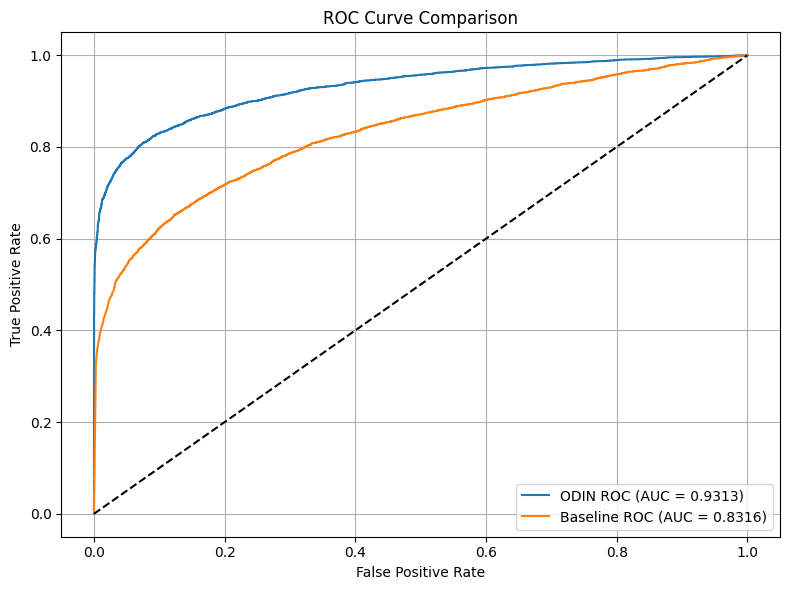

In [16]:
y_fake_ODIN = torch.zeros_like(scores_fake_ODIN)
y_test_ODIN = torch.ones_like(scores_test_ODIN)
ypred_ODIN = torch.cat((scores_test_ODIN, scores_fake_ODIN))
ytrue_ODIN = torch.cat((y_test_ODIN, y_fake_ODIN))

# Compute ROC curve and AUC for ODIN
fpr_ODIN, tpr_ODIN, _ = metrics.roc_curve(ytrue_ODIN, ypred_ODIN.detach().numpy())
roc_auc_ODIN = metrics.auc(fpr_ODIN, tpr_ODIN)

# Prepare true labels and predictions for regular scores
y_fake = torch.zeros_like(scores_fake)
y_test = torch.ones_like(scores_test)
ypred = torch.cat((scores_test, scores_fake))
ytrue = torch.cat((y_test, y_fake))

# Compute ROC curve and AUC for regular scores
fpr, tpr, _ = metrics.roc_curve(ytrue, ypred)
roc_auc = metrics.auc(fpr, tpr)

# Plot both ROC curves on the same figure
plt.figure(figsize=(8, 6))
plt.plot(fpr_ODIN, tpr_ODIN, label=f'ODIN ROC (AUC = {roc_auc_ODIN:.4f})')
plt.plot(fpr, tpr, label=f'Baseline ROC (AUC = {roc_auc:.4f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Come richiesto ho implementato una grid search per trovare i parametri migliori per il nostro problema

In [17]:
temperature = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
eps =  np.linspace(0, 0.004, 21)
std_dev = 0.5
best_fpr = 100
n=0
tot = len (temperature) * len(eps) 
for T in temperature:
    for magnitude in eps:

        
        scores_test_ODIN = []
        model.eval()
        for data in testloader:  
            model.zero_grad()
            x,y_true = data
            x,y_true = x.to(device), y_true.to(device)
            x.requires_grad_()
            logits = model(x) 
            prob = F.softmax(logits/T, 1)
            y_pred = torch.argmax(prob)
            
            if(y_pred ==  y_true):
                 
                 l = F.cross_entropy(prob, torch.unsqueeze(y_pred,0).to(device))
                 l.backward()
                 gradient_sign = x.grad.data.sign()
                 x.grad.zero_()
                 gradient_sign = gradient_sign/std_dev 
                 scores_test_ODIN.append(ODIN(gradient_sign, x, magnitude, T))
                       
        scores_test_ODIN = torch.cat(scores_test_ODIN) 
            
        scores_fake_ODIN = []
        model.eval()
        for data in fakeloader: 
            if len(scores_fake_ODIN) >=  len(scores_test_ODIN):
                break
                
            model.zero_grad()
            x,_ = data
            x = x.to(device)
            x.requires_grad_()
            logits = model(x) 
            prob = F.softmax(logits/T, 1)
            y_pred = torch.argmax(prob)
            y_pred = torch.unsqueeze(y_pred,0)
            l = F.cross_entropy(prob,y_pred)
            l.backward()
            gradient_sign = x.grad.data.sign()/std_dev 
            x.grad.zero_()
            scores_fake_ODIN.append(ODIN(gradient_sign, x, magnitude, T) )
            
                         
        scores_fake_ODIN = torch.cat(scores_fake_ODIN) 


        y_fake_ODIN = torch.zeros_like(scores_fake_ODIN)
        y_test_ODIN = torch.ones_like(scores_test_ODIN)
        ypred_ODIN = torch.cat((scores_test_ODIN, scores_fake_ODIN))
        ytrue_ODIN = torch.cat((y_test_ODIN, y_fake_ODIN))
        fpr_ODIN, tpr_ODIN, thresholds_ODIN = metrics.roc_curve(ytrue_ODIN, ypred_ODIN.detach().numpy())
        idx_ODIN = np.argmin(np.abs(tpr_ODIN - 0.95))
        fpr_at_95_ODIN = fpr_ODIN[idx_ODIN]
        n += 1
        print(f'Tempearture: {T}, Epsilon: {magnitude}, FPR at 95% TPR:{fpr_at_95_ODIN}     {n}/{tot}') 
        if fpr_at_95_ODIN < best_fpr:
            best_ypred = ypred_ODIN
            best_ytrue = ytrue_ODIN
            bestT = T
            bestEps = magnitude
            best_fpr = fpr_at_95_ODIN
            print("is the new best")
        print("--------------------------------")
        print()
    print()
    print()

print( f'Best performance Temperature:{bestT}  Epsilon: {bestEps}, FPR at 95% TPR:{best_fpr}')


Tempearture: 1, Epsilon: 0.0, FPR at 95% TPR:0.7712009995314696     1/210
is the new best
--------------------------------
Tempearture: 1, Epsilon: 0.0002, FPR at 95% TPR:0.752928314852413     2/210
is the new best
--------------------------------
Tempearture: 1, Epsilon: 0.0004, FPR at 95% TPR:0.7338747462127128     3/210
is the new best
--------------------------------
Tempearture: 1, Epsilon: 0.0006000000000000001, FPR at 95% TPR:0.717163829454943     4/210
is the new best
--------------------------------
Tempearture: 1, Epsilon: 0.0008, FPR at 95% TPR:0.7002967359050445     5/210
is the new best
--------------------------------
Tempearture: 1, Epsilon: 0.001, FPR at 95% TPR:0.6845228799000469     6/210
is the new best
--------------------------------
Tempearture: 1, Epsilon: 0.0012000000000000001, FPR at 95% TPR:0.6665625488052476     7/210
is the new best
--------------------------------
Tempearture: 1, Epsilon: 0.0014, FPR at 95% TPR:0.6489145712947056     8/210
is the new best
-

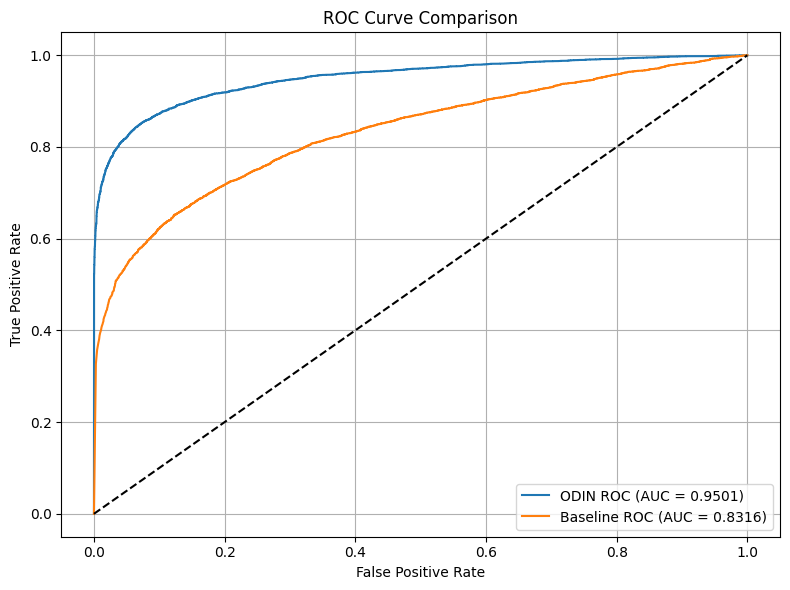

In [18]:
fpr_ODIN, tpr_ODIN, _ = metrics.roc_curve(best_ytrue, best_ypred.detach().numpy())
roc_auc_ODIN = metrics.auc(fpr_ODIN, tpr_ODIN)

# Prepare true labels and predictions for regular scores
y_fake = torch.zeros_like(scores_fake)
y_test = torch.ones_like(scores_test)
ypred = torch.cat((scores_test, scores_fake))
ytrue = torch.cat((y_test, y_fake))

# Compute ROC curve and AUC for regular scores
fpr, tpr, _ = metrics.roc_curve(ytrue, ypred)
roc_auc = metrics.auc(fpr, tpr)

# Plot both ROC curves on the same figure
plt.figure(figsize=(8, 6))
plt.plot(fpr_ODIN, tpr_ODIN, label=f'ODIN ROC (AUC = {roc_auc_ODIN:.4f})')
plt.plot(fpr, tpr, label=f'Baseline ROC (AUC = {roc_auc:.4f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()  